In [28]:
import ot
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plt.rcParams['mathtext.fontset'] = 'custom' 
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans' 
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic' 
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold' 
plt.rcParams['font.size'] = 16 
plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral' 

In [309]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype(float) - 122.5) / 255

In [310]:
ind_cls = [np.where(y_train == i)[0] for i in np.unique(y_train)]

In [311]:
x_train.shape

(60000, 28, 28)

In [312]:
X = []
y = []

ind_cls = [np.where(y_train == i)[0] for i in np.unique(y_train)]
for ind in ind_cls:
    X.append(x_train[ind[:500]].reshape(-1, 28 * 28))
    y.append(y_train[ind[:500]])

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

## Euclidean Barycenter

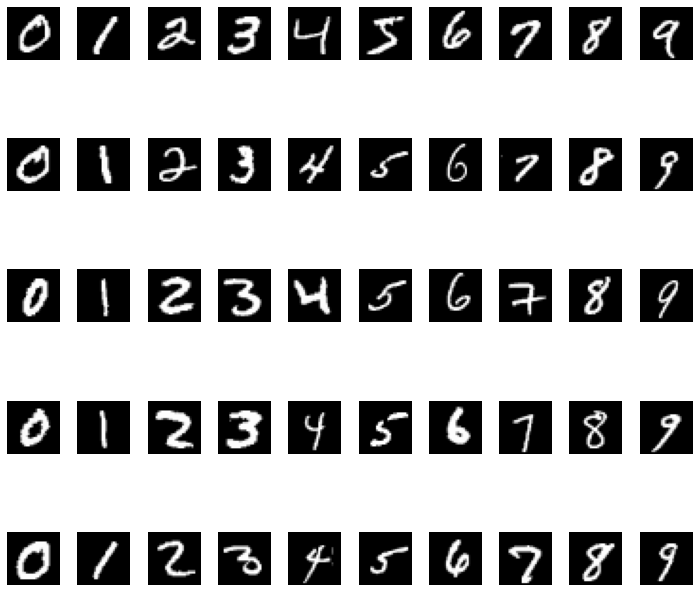

In [313]:
fig, axes = plt.subplots(5, 10, figsize=(10, 10))
for i in range(5):
    for j in range(10):
        axes[i, j].imshow(X[np.where(y == j)[0]][i].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
plt.tight_layout()
plt.savefig('../Figures/Digits.svg')

In [314]:
euclidean_barycenters = [
    np.mean(X[np.where(y == i)[0][:10]], axis=0).reshape(28, 28) for i in range(10)
]

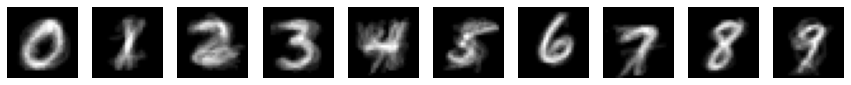

In [315]:
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i in range(10):
    axes[i].imshow(euclidean_barycenters[i], cmap='gray')
    axes[i].axis('off')

## Wasserstein Barycenters

In [316]:
from skimage.io import imsave

In [326]:
def wasserstein_barycenter(Y, b, Xini=None, theta=0.5, max_iter=100, tol=1e-9, reg=0.0, verbose=False,
                           metric='sqeuclidean'):
    n_support = len(Y[0])
    n_domains = len(Y)
    
    if Xini is None:
        X = np.zeros([n_support,])
    else:
        X = Xini.copy()
    a = ot.unif(n_support)
    
    it = 0
    log = {'Barycenter': []}
    prev_X = X.copy()
    while it < max_iter:
        M = []
        G = []
        for (Yi, bi) in zip(Y, b):
            Mi = ot.dist(X[..., np.newaxis], Yi[..., np.newaxis], metric=metric)
            # Mi = Mi / np.max(Mi)
            if reg == 0.0:
                Gi = ot.emd(a, bi, Mi)
            else:
                Gi = ot.sinkhorn(a, bi, Mi, reg=reg)
            G.append(Gi)
        tmp = (sum([np.dot(Gi.T, Yi) for Gi, Yi in zip(G, Y)]))
        X = (1 - theta) * X + theta * np.dot(np.diag(1 / a), tmp) / n_domains
        delta = np.linalg.norm(X - prev_X)
        print(it, delta)
        log['Barycenter'].append(X)
        it += 1
        prev_X = X.copy()
        
        if delta < tol:
            return X, log
    return X, log

In [327]:
wasserstein_barycenters = []
logs = []
for digit in range(10):
    Y = [X[np.where(y == digit)][i] for i in range(10)]
    b = [ot.unif(Yi.shape[0]) for Yi in Y]
    Xbar, log = wasserstein_barycenter(Y, b, theta=0.5, max_iter=15, reg=1e-2, verbose=False,
                                       metric='cityblock')
    wasserstein_barycenters.append(Xbar)
    logs.append(log)

0 4.09943277310924
1 2.0497163865546146
2 1.024858193277323
3 0.5124290966386505
4 0.2562145483193415
5 0.12810727415966017
6 0.06405363707983497
7 0.03202681853990252
8 0.016013409270000434
9 0.008006704643567
10 0.004003353959181877
11 0.0020019903249313795
12 0.0010592653329708093
13 0.0034336545362503986
14 0.03352844687591217
0 5.579432773109235
1 2.789716386554611
2 1.3948581932773112
3 0.6974290966386691
4 0.34871454831935406
5 0.17435727415964006
6 0.08717863707982274
7 0.043589318539926536
8 0.021794659269951284
9 0.01089732963496497
10 0.00544866481748663
11 0.0027243324087426247
12 0.0013621662043967273
13 0.000681083102778278
14 0.00034054157411095916
0 4.426652661064421
1 2.213326330532209
2 1.1066631652661043
3 0.553331582633065
4 0.2766657913165366
5 0.13833289565826146
6 0.06916644782911957
7 0.03458322391457157
8 0.017291611957293063
9 0.008645805978632183
10 0.004322902989450741
11 0.0021614515078684123
12 0.001080727037474575
13 0.0005404888235044494
14 0.00028221247

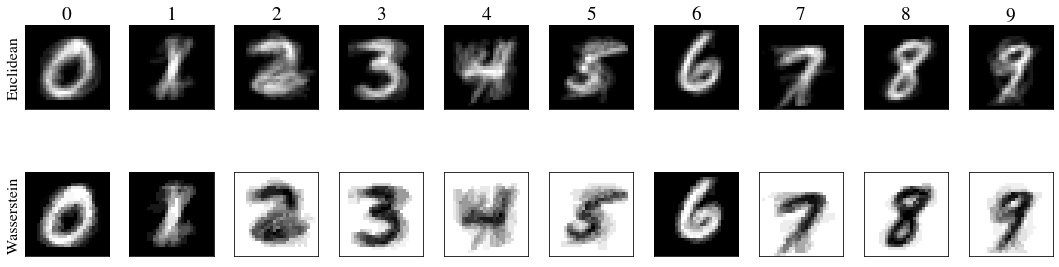

In [329]:
fig, axes = plt.subplots(2, 10, figsize=(15, 5))

for i in range(10):
    axes[0, i].imshow(euclidean_barycenters[i], cmap='gray')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[0, i].set_title(i)
    
    axes[1, i].imshow(wasserstein_barycenters[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
axes[0, 0].set_ylabel('Euclidean')
axes[1, 0].set_ylabel('Wasserstein')
plt.tight_layout()
    
plt.savefig('../Figures/ComparisonBarycenters.svg')